In [2]:
import subprocess

def blame(file):
    return subprocess.run(["git", "blame", "--line-porcelain", file],
       capture_output=True,
       cwd=repo_root
    ).stdout.decode("utf8")

def git_ls_files(repo_root, dir=None):
    args = ["git", "ls-files"]
    if dir is not None:
        args.append(dir) 
        
    p = subprocess.run(args,
       capture_output=True,
       cwd=repo_root
    )
    
    if p.returncode != 0:
        return p.stderr.decode("utf8")
    return p.stdout.decode("utf8").split("\n")

def add_lines(counts, author, start, end):
    if author not in counts:
        counts[author] = 0
        
    diff = end - start
    counts[author] += diff

def count_file(f):
    counts = {}

    last_author_header_ln = 1
    last_header_ln = 1
    last_author_name = None

    blame_lines = blame(path.join(repo_root, f)).split("\n")

    for j, line in enumerate(blame_lines):
        if line == "":
            continue

        header_match = header_re.match(line)
        if header_match is not None:
            header_new_ln = int(header_match.group(1))
            last_header_ln = int(header_new_ln)
            continue

        author_match = author_re.match(line)
        if author_match is not None:
            author = author_match.group(1)
            if last_author_name is None:
                last_author_name = author
                continue
            

            add_lines(counts, last_author_name, last_author_header_ln, last_header_ln)
            
            last_author_name = author
            last_author_header_ln = last_header_ln
            
            
    add_lines(counts, last_author_name, last_author_header_ln, last_header_ln + 1)
    
    return f, counts

In [24]:
import re, time, os.path as path
from multiprocessing import Pool
from math import ceil

start = time.time()

pool_size = 100
limit = 1e100
# limit = 100
root_dir = "/home/bwhite/Projects/bryanchriswhite"
repo_names = [
    "storj",
    # "uplink"
    # "uplink-c"
]
author_regex = re.compile("\S+\s+\(([\w ]+)\s*?\d{4,}")

header_re = re.compile("\w{,40} \d+ (\d+)(:? (\d+))?")
author_re = re.compile("author (.+)$")

files_author_line_counts = {}


def filter_files(filename):
    ext = path.splitext(f)[1]
    return filename == "" #or ext != ".go"


def cb(result):
    filename, counts = result
    if filename not in files_author_line_counts:
        files_author_line_counts[filename] = counts

def cb_error(error):
    print(str.format("error: {}", error))

for name in repo_names:
    repo_root = path.join(root_dir, name)
    files = git_ls_files(repo_root=repo_root)
    i = 0
    with Pool(pool_size) as pool:
        for f in files:
            if filter_files(f):
                continue
            
            i += 1
            if i <= limit:
                pool.apply_async(count_file, [f], callback=cb, error_callback=cb_error).get()
                    
print(str.format("done: {}s!", ceil(time.time() - start)))


done: 1s!


In [25]:
totals = {}
total_lines = 0

for author_line_counts in files_author_line_counts.values():
    for author, counts in author_line_counts.items():
        total_lines += counts
        if author not in totals:
            totals[author] = 0
        totals[author] += counts
        
total_list = list(totals.items())
to_percent = lambda tup, total: round((tup[1] / total) * 100)


total_list = [(*tup, to_percent(tup, total_lines)) for tup in total_list]
total_list.sort(key=lambda x: x[1], reverse=True)
total_list = [(i+1, *tup) for i, tup in enumerate(total_list)]

def print_totals(totals):
    for i, author, total, pct in totals:
        print(str.format("#{}: {} ({}% | {})", i, author, pct, total))
        
print_totals(total_list[:10])


#1: Egon Elbre (86% | 3645)
#2: Michal Niewrzal (10% | 427)
#3: Kaloyan Raev (4% | 149)


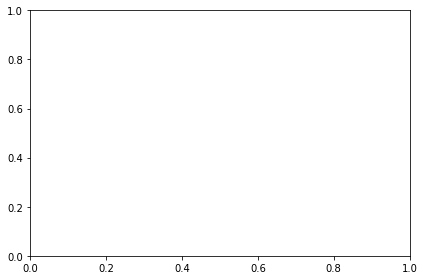

In [13]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.bar()

fig.tight_layout()
plt.show()
                    

In [4]:
for f, author_line_counts in files_author_line_counts.items():
    print(f)
    for author, line_count in author_line_counts.items():
        print(str.format("    {}: {}", author, line_count))
                    

certificate/authorization/authorizations.go
    Bryan White: 174
    Jeff Wendling: 2
    Egon Elbre: 3
certificate/authorization/authorizations_test.go
    Jennifer Li Johnson: 1
    Bryan White: 168
    Egon Elbre: 56
    ethanadams: 7
    Isaac Hess: 1
    JT Olio: 2
    Stefan Benten: 1
    Jeff Wendling: 3
    Yingrong Zhao: 1
certificate/authorization/db.go
    Bryan White: 294
    Egon Elbre: 3
    Jennifer Johnson: 1
certificate/authorization/db_test.go
    Bryan White: 411
    Egon Elbre: 5
certificate/authorization/doc.go
    Bryan White: 8
certificate/authorization/endpoint.go
    Bryan White: 110
certificate/authorization/endpoint_test.go
    Bryan White: 137
    Egon Elbre: 2
certificate/authorization/service.go
    Bryan White: 71
    Stefan Benten: 5
certificate/authorization/service_test.go
    Bryan White: 71
    Egon Elbre: 1
certificate/certificateclient/client.go
    Bryan White: 78
    Jeff Wendling: 8
    paul cannon: 1
    Egon Elbre: 7
    Yingrong Zhao: 1
certi

In [17]:
from github import Github

apikey = open("github.apikey")

g = Github()
org = g.get_organization("storj")
repos = org.get_repos()
page = repos.get_page(0)

storj_repos = page

NameError: name 'Github' is not defined

In [6]:
[(r.name, r.created_at) for r in storj_repos]

UnsupportedOperation: read